In [1]:
import pandas as pd

In [2]:
!cd

C:\Users\Paco\Documents\site_similarity\notebooks\node_features_graphs


In [3]:
node_features_file = "../generate_node_features/corpus_2018_audience_overlap_level_0_and_1_node_features.csv"
edge_file = "../generate_node_features/corpus_2018_audience_overlap_level_0_and_1_edges.csv"

In [4]:
node_features_df = pd.read_csv(node_features_file, index_col=0)

In [5]:
node_features_df.head()

,alexa_ranks,daily_pageviews_per_visitors,daily_time_on_sites,total_sites_linking_ins,bounce_rate
urls,,,,,
crotonmusiccenter.com,NaN,NaN,NaN,NaN,NaN
gracefuneralhome.com,NaN,NaN,NaN,4.0,NaN
haaretz.com,11522.0,1.5,152.0,13974.0,0.650
osubeavers.com,422967.0,2.5,299.0,430.0,0.471
prophezine.com,8782212.0,1.0,NaN,209.0,NaN


In [6]:
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11865 entries, crotonmusiccenter.com to yorkregion.com
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alexa_ranks                   8658 non-null   float64
 1   daily_pageviews_per_visitors  8659 non-null   float64
 2   daily_time_on_sites           6459 non-null   float64
 3   total_sites_linking_ins       11470 non-null  float64
 4   bounce_rate                   6023 non-null   float64
dtypes: float64(5)
memory usage: 556.2+ KB


In [7]:
node_features_df.alexa_ranks = node_features_df.alexa_ranks.fillna(0)
node_features_df.total_sites_linking_ins = node_features_df.total_sites_linking_ins.fillna(0)

In [8]:
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11865 entries, crotonmusiccenter.com to yorkregion.com
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alexa_ranks                   11865 non-null  float64
 1   daily_pageviews_per_visitors  8659 non-null   float64
 2   daily_time_on_sites           6459 non-null   float64
 3   total_sites_linking_ins       11865 non-null  float64
 4   bounce_rate                   6023 non-null   float64
dtypes: float64(5)
memory usage: 556.2+ KB


# Normalizing features

In [9]:
node_features_df['normalized_alexa_rank'] = node_features_df['alexa_ranks'].apply(lambda x: 1/x if x else 0)

In [10]:
import math

node_features_df['normalized_total_sites_linked_in'] = node_features_df['total_sites_linking_ins'].apply(lambda x: math.log2(x) if x else 0)

---

In [11]:
edge_df = pd.read_csv(edge_file)

edge_df.head()

,source,target
0,villagevoice.com,nylon.com
1,villagevoice.com,slantmagazine.com
2,villagevoice.com,gothamist.com
3,villagevoice.com,screendaily.com
4,villagevoice.com,amny.com


In [12]:
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20399 entries, 0 to 20398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  20399 non-null  object
 1   target  20399 non-null  object
dtypes: object(2)
memory usage: 318.9+ KB


In [13]:
import stellargraph as sg

In [15]:
G = sg.StellarGraph(node_features_df[['normalized_alexa_rank', 'normalized_total_sites_linked_in']], edge_df)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 11865, Edges: 20399

 Node types:
  default: [11865]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [20399]
        Weights: all 1 (default)
        Features: none


# Unsupervised Deep Graph Infomax

In [16]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from tensorflow import keras

1. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

In [17]:
nodes = list(G.nodes())
number_of_walks = 1
length = 5

2. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [18]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [19]:
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

3. Create a node pair generator:

In [20]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

deep_graph_infomax_model = Model(inputs=x_in, outputs=x_out)
deep_graph_infomax_model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [23]:
from stellargraph.utils import plot_history

  ...
    to  
  ['...']


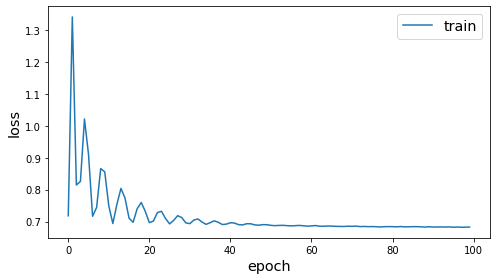

In [24]:
epochs = 100

es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = deep_graph_infomax_model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [25]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

In [26]:
node_features_fullbactch_generator = fullbatch_generator.flow(node_features_df.index)
node_embeddings = emb_model.predict(node_features_fullbactch_generator)

In [27]:
embeddings_wv = dict(zip(node_features_df.index.tolist(), node_embeddings))

In [28]:
embeddings_wv['villagevoice.com']

array([0.        , 0.        , 0.        , 1.0197926 , 1.8971097 ,
       1.9910862 , 1.8161272 , 0.        , 0.        , 0.0483317 ,
       0.        , 1.0879946 , 0.        , 0.        , 0.74764615,
       0.        , 0.57834876, 1.7653457 , 0.        , 1.3357807 ,
       0.        , 0.41865766, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0977762 ,
       0.        , 0.        , 1.611587  , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.696543  , 0.        ,
       0.9462551 , 0.69303846, 1.9709584 , 1.4316486 , 1.5908962 ,
       0.1233526 , 0.        , 1.1008766 , 0.        , 0.        ,
       0.48515537, 0.        , 0.        , 1.9860827 , 0.        ,
       0.        , 1.7080257 , 0.        , 0.        , 1.5659837 ,
       0.        , 1.0793707 , 0.9441719 , 0.        , 1.2896321 ,
       0.        , 0.        , 0.        , 0.0538427 , 0.        ,
       0.        , 2.0209663 , 0.        , 0.5207838 , 0.     

In [29]:
class ModelWrapper:
    def __init__(self, embeddings_wv):
        self.wv = embeddings_wv
        
    def __str__(self):
        return 'Unsupervised Deep Graph Infomax'

In [31]:
import sys,os
sys.path.append("C:\\Users\\Paco\\Documents\\site_similarity")

In [32]:
from utils.notebook_utils import train_model

In [33]:
data_year = '2018'
node2vec_model = ModelWrapper(embeddings_wv)

In [34]:
! cd

C:\Users\Paco\Documents\site_similarity\notebooks\node_features_graphs


In [35]:
%run ../../utils/notebook_utils.py

In [34]:
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV

In [36]:
result_report = []

clf = LogisticRegressionCV(Cs=10, cv=5, scoring="accuracy", multi_class="ovr", max_iter=300, random_state=42)
result_report.append([
    str(node2vec_model),
    'LogisticRegression CV = 5',
    *list(train_model(clf, node2vec_model=node2vec_model, data_year=data_year).values())
]);

clf2 = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", multi_class="ovr", max_iter=300, random_state=42)
result_report.append([
    str(node2vec_model),
    'LogisticRegression CV = 10',
    *list(train_model(clf2, node2vec_model=node2vec_model, data_year=data_year).values())
]);

tree_clf = GradientBoostingClassifier(random_state=42)
result_report.append([
    str(node2vec_model),
    'GradientBoostingClassifier',
    *list(train_model(tree_clf, node2vec_model=node2vec_model, data_year=data_year).values())
]);

svm_clf = svm.SVC(decision_function_shape='ovo', probability=True, random_state=42)
result_report.append([
    str(node2vec_model),
    'SVC ovo',
    *list(train_model(svm_clf, node2vec_model=node2vec_model, data_year=data_year).values())
]);

model_res = pd.DataFrame(result_report,
                    columns=["Feature", "Classifier", "Accuracy", "Balanced Accuracy score",
                             "F1 micro score", "F1 macro score", "F1 weighted score", "MAE", "Confusion matrix"])

Start training...
Start training...
Start training...
Start training...


In [37]:
model_res.head()

,Feature,Classifier,Accuracy,Balanced Accuracy score,F1 micro score,F1 macro score,F1 weighted score,MAE,Confusion matrix
0,Unsupervised Deep Graph Infomax,LogisticRegression CV = 5,0.599061,0.489972,0.599061,0.428332,0.506685,0.550235,"[[141, 0, 114], [75, 0, 193], [45, 0, 497]]"
1,Unsupervised Deep Graph Infomax,LogisticRegression CV = 10,0.600000,0.487126,0.600000,0.426826,0.506225,0.548357,"[[136, 0, 119], [74, 0, 194], [39, 0, 503]]"
2,Unsupervised Deep Graph Infomax,GradientBoostingClassifier,0.547418,0.459782,0.547418,0.441686,0.510089,0.594366,"[[119, 47, 89], [78, 30, 160], [62, 46, 434]]"
3,Unsupervised Deep Graph Infomax,SVC ovo,0.600939,0.500137,0.600939,0.433977,0.513156,0.546479,"[[153, 0, 102], [96, 1, 171], [55, 1, 486]]"
